An exploration of different tests, comparing them in terms of the conditions (and the p-value distribution if these are violated) and the power.

In particular, this will focus in the Student's t-test, Welch's t-test, and Mann-Whitney test.

In [167]:
from scipy import stats
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

In [103]:
def get_p_values(dist1, dist2, test, n=10, n_trials=10000):
    p_values = []
    for _ in range(n_trials):
        sample_a = dist1.rvs(n)
        sample_b = dist2.rvs(n)
        result = test(sample_a, sample_b)
        p_values.append(result[1])
    return p_values

First, compare identical distributions as a baseline.

In [31]:
p_values = get_p_values(stats.norm(0, 1),
                        stats.norm(0, 1),
                        stats.ttest_ind,
                        10,
                        10000)

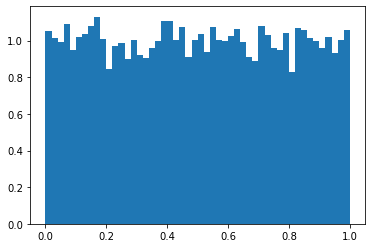

In [32]:
fig, ax = plt.subplots()
ax.hist(p_values, bins=50, density=True);

Next, look at the same for unequal variances.

In [33]:
p_values = get_p_values(stats.norm(0, 1),
                        stats.norm(0, 5),
                        stats.ttest_ind,
                        10,
                        10000)

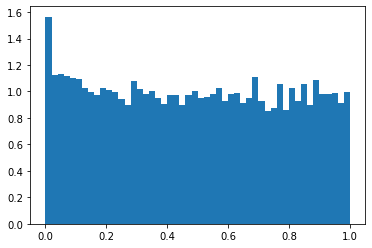

In [34]:
fig, ax = plt.subplots()
ax.hist(p_values, bins=50, density=True);

Check whether changing the test to allow uneuqal variances fixes that.

In [39]:
p_values = get_p_values(stats.norm(0, 1),
                        stats.norm(0, 5),
                        partial(stats.ttest_ind,
                                equal_var=False),
                        10,
                        10000)

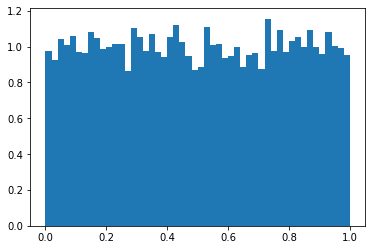

In [40]:
fig, ax = plt.subplots()
ax.hist(p_values, bins=50, density=True);

What if we use non-normal distributions?

In [81]:
p_values = get_p_values(stats.uniform(0, 1),
                        stats.uniform(0, 1),
                        partial(stats.ttest_ind,
                                equal_var=True),
                        10,
                        500000)

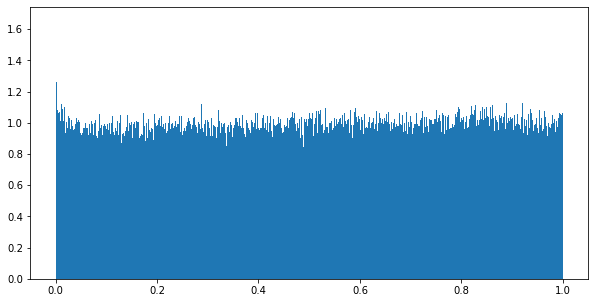

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(p_values, bins=1000, density=True);

Let's zoom in.

(0.0, 0.01)

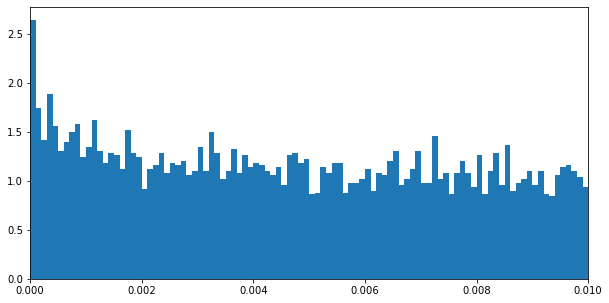

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(p_values, bins=10000, density=True);
ax.set_xlim(0, 0.01)

In [136]:
p_values = get_p_values(stats.expon(0, 1),
                        stats.expon(0, 1),
                        partial(stats.ttest_ind,
                                equal_var=True),
                        100,
                        3000000)

(0.0, 1.0)

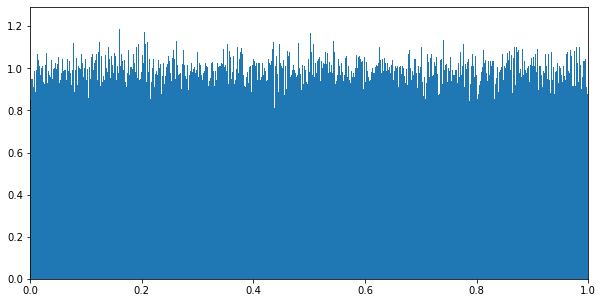

In [144]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(p_values, bins=10000, density=True);
ax.set_xlim(0, 1)

In [147]:
p_values = np.array(p_values)

In [155]:
sum(p_values < len(p_values)*0.05)

3000000

In [166]:
p_values[(p_values < 0.00005)]

array([3.51202746e-05, 1.33314289e-05, 3.09422729e-05, 6.75120734e-06,
       4.65526376e-05, 9.93453692e-06, 3.57650550e-05, 3.95082296e-05,
       3.70402276e-05, 2.59282373e-05, 2.17660392e-05, 7.25387071e-06,
       4.90665392e-05, 3.53332849e-05, 4.53275720e-05, 2.81819837e-05,
       2.87248474e-05, 3.98830329e-05, 2.72817233e-05, 4.60545030e-06,
       4.36230357e-05, 4.24821619e-05, 1.37440742e-05, 1.19177761e-05,
       5.22075009e-06, 3.15905306e-05, 5.40624483e-07, 6.69554763e-06,
       1.60998874e-05, 4.14853567e-05, 1.91694997e-05, 5.67176805e-06,
       2.71351778e-05, 3.89096317e-05, 2.04970206e-05, 2.17112555e-05,
       2.22871252e-05, 9.60451622e-07, 4.12903035e-05, 4.89689881e-05,
       3.20333666e-05, 6.47752911e-06, 3.06990166e-05, 1.51867409e-05,
       1.61171734e-05, 4.62410351e-05, 4.94319920e-05, 3.76154375e-05,
       3.07671919e-06, 3.41804536e-05, 3.08280942e-06, 3.69358531e-05,
       4.61141957e-05, 1.47041675e-05, 4.82774258e-05, 1.18543763e-05,
      

I wonder if the behavior at p=0 is a function of kurtosis (the exponential distribution has a large kurtosis, and the uniform distribution has a small one).

Let's try something extreme.

In [78]:
p_values = get_p_values(stats.cauchy(1),
                        stats.cauchy(1),
                        partial(stats.ttest_ind,
                                equal_var=True),
                        10,
                        50000)

(0.0, 1.0)

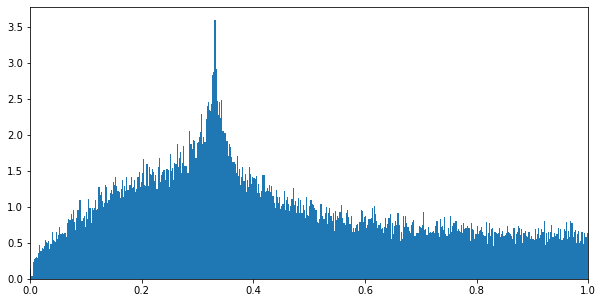

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(p_values, bins=500, density=True);
ax.set_xlim(0, 1)

Whoa.

How does Mann-Whitney do?

In [111]:
p_values = get_p_values(stats.norm(0, 1),
                        stats.norm(0, 1),
                        partial(stats.mannwhitneyu,
                                alternative='less'),
                        10,
                        100000)

(0.0, 1.0)

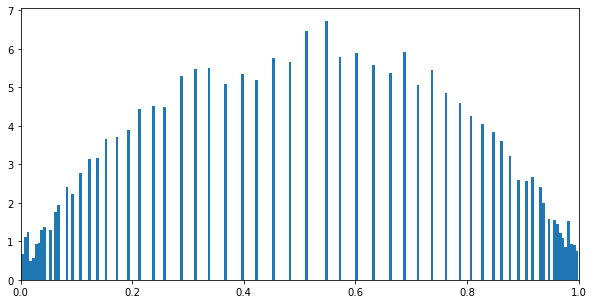

In [121]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(p_values, bins=200, density=True);
ax.set_xlim(0, 1)

That's pretty discretized.

## Fitting to GEVD

We should be able to understand the behavior at the maximum by a weighted fit to the Generalized Extreme Value Distribution. Specifically we'd use the Weibull distribution, since there's a hard minimum and not an exponential or polynomial tail.

To do this we could take bootstrap samples of the sample, get the maxima, and fit those to the Weibull. More efficiently, we could weight the smallest values based on the order from smallest, with the weighting based on the expected frequency in a bootstrap sample.

Unfortunately scipy doesn't allow distribution fitting with weighted samples. So either I have to hack that in, or find a different library.


First, let's look at the Weibull distribution I'll be fitting to.

/Users/jackbennetto/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2051: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


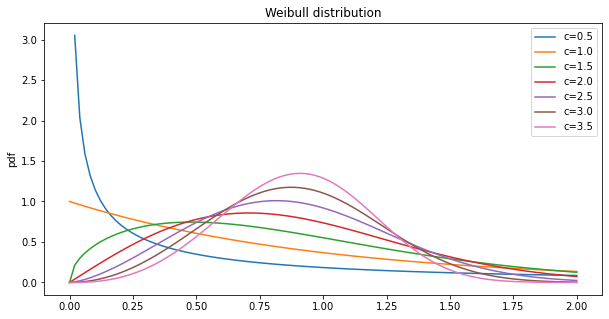

In [216]:
fig, ax = plt.subplots(figsize=(10, 5))
xpts = np.linspace(0, 2, 100)
for c in np.arange(0.5, 4, 0.5):
    ax.plot(xpts, stats.weibull_min(c).pdf(xpts), label=f'c={c}')
ax.set_ylabel('pdf')
ax.set_title('Weibull distribution')
ax.legend();

Let's zoom in a bit for values of `c` near 1.

/Users/jackbennetto/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2051: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))
/Users/jackbennetto/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2051: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))
/Users/jackbennetto/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2051: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))
/Users/jackbennetto/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2051: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


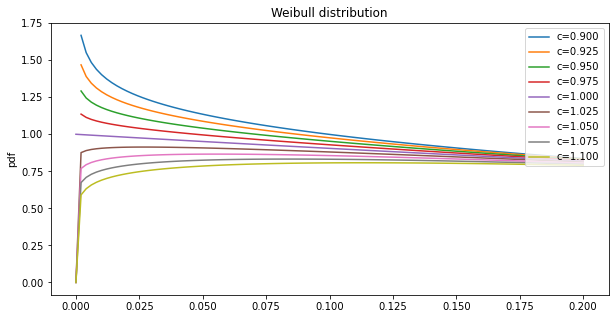

In [391]:
fig, ax = plt.subplots(figsize=(10, 5))
xpts = np.linspace(0, 0.2, 100)
for c in np.arange(0.9, 1.1, 0.025):
    ax.plot(xpts, stats.weibull_min(c).pdf(xpts), label=f'c={c:.3f}')
ax.set_ylabel('pdf')
ax.set_title('Weibull distribution')
ax.legend(loc='upper right');

### Curve fitting

I'm playing around with `scipy.optimize` to try to fit a curve.

First, try something I understand.

In [183]:
def normal_log_likelihood(params, xs):
    dist = stats.norm(params[0], params[1])
    ll = 0
    for x in xs:
        ll -= dist.logpdf(x)
    return ll

In [244]:
xs = [1, 2.1, 3.2, 0.5, 3.5, 0.7, 7]
result = optimize.minimize(normal_log_likelihood,
                           x0=[0, 1],
                           args=xs)
result.x

array([2.57142804, 2.11640875])

In [245]:
np.mean(xs), np.std(xs)

(2.5714285714285716, 2.1164082010494547)

So that worked.

In [251]:
def weibull_log_likelihood(params, xs):
    dist = stats.weibull_min(params[0], 0, params[1])
    return -sum(dist.logpdf(x) for x in xs)

In [252]:
result = optimize.minimize(weibull_log_likelihood,
                           x0=[1, 1],
                           args=(xs,))
result

      fun: 13.346987404179835
 hess_inv: array([[0.13340193, 0.09903122],
       [0.09903122, 0.73964248]])
      jac: array([2.38418579e-07, 1.19209290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 10
     njev: 12
   status: 0
  success: True
        x: array([1.25183098, 2.77385152])

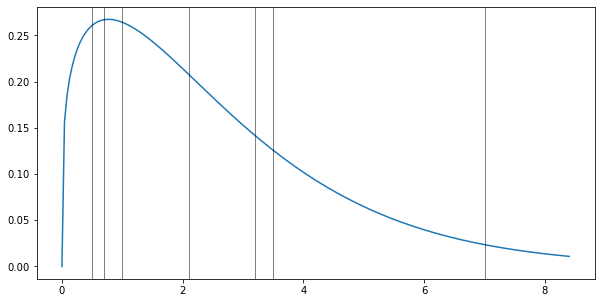

In [253]:
xpts = np.linspace(0, np.max(xs)*1.2, 200)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xpts,
        stats.weibull_min(result.x[0], 0, result.x[1]).pdf(xpts))
for x in xs:
    ax.axvline(x, color='k', lw=0.5)

Okay, now we try this for real.

In [255]:
def weibull_weighted_log_likelihood(params, xs, weights):
    dist = stats.weibull_min(params[0], 0, params[1])
    return -sum(weight * dist.logpdf(x)
                for x, weight
                in zip(xs, weights))

In [320]:
def weibull_fit(xs, weights):
    result = optimize.minimize(weibull_weighted_log_likelihood,
                               x0=[1, 1],
                               args=(xs, weights))
    print(result)
    return result.x   

In [321]:
weibull_fit([1,2,3,4],
            [5,1,1,1])

      fun: 10.725694217805843
 hess_inv: array([[0.2125122 , 0.06831118],
       [0.06831118, 0.17768549]])
      jac: array([ 7.15255737e-07, -1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 33
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([1.76004839, 1.98642691])


array([1.76004839, 1.98642691])

Now try the actual idea. Here we pass in a bunch of p-values and do extreme-value fit (assuming a Weibull distribution with a minimum at 0 since we know that must be true).

The extreme-value theorem says that the minimums of a bunch of samples fits to an extreme value distribution. Since we just have one sample, we could simulate that be sub-sampling. Or we could just weight the values based on the probability they would be the smallest value of a subsample. We use a `fraction` parameter as the probability any given sample will be included in the subsample.


In [335]:
def ev_fit(xs, fraction, n=100):
    xs = np.sort(xs)[:n] * 1000
    weights = (1 - fraction) ** np.arange(n)
    #print(xs, weights)
    return weibull_fit(xs, weights)

In [381]:
xs = stats.uniform(0, 1).rvs(1000000)

In [385]:
ev_fit(xs, 0.001, 5000)

      fun: 990.05886306689
 hess_inv: array([[ 0.00026328, -0.00024407],
       [-0.00024407,  0.00049445]])
      jac: array([ 6.10351562e-05, -7.62939453e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 115
      nit: 6
     njev: 35
   status: 2
  success: False
        x: array([1.04798724, 1.01688526])


array([1.04798724, 1.01688526])

In [325]:
weibull_fit([1.9526929, 0.17408832, 0.2352351, 0.32896892, 0.8291631 ],
            [1., 1, 1, 1, 1])

      fun: 3.1845516547128785
 hess_inv: array([[0.1439285 , 0.04190917],
       [0.04190917, 0.09387472]])
      jac: array([ 5.06639481e-07, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([1.12870789, 0.73959008])


array([1.12870789, 0.73959008])

In [384]:
(1-.001)** 5000

0.006721111959865588